# Exploring datasets: Exercise chat

Let's return to the `chat` dataset from Week 1.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Note that a proper exploration of your data (both in 'numbers' and visually, by means of a plot) should always precede any statistical analysis.

## Loading and inspecting the data

Load  `datasets/chat/chat.tsv`

In [2]:
chat = pd.read_csv("../../datasets/chat/chat.tsv", sep="\t")
chat

,nr_tokens,subject_ID,gender,education,emoticons,nonstd_Dutch
0,1487,1,male,general,49,292
1,1859,2,male,technical,49,298
2,178,3,male,general,0,32
3,258,4,female,general,0,53
4,48,5,male,vocational,0,3
...,...,...,...,...,...,...
1379,287,1380,female,technical,4,68
1380,407,1381,female,technical,25,66
1381,613,1382,female,general,1,96
1382,1657,1383,female,vocational,74,410


Create a new categorical variable: was the participant's submission to the research project large (>500 tokens of chat data) or small (<=500 tokens)?

Here we introduce a pandas method called `apply()`. You can use this on `Series` (as here) or whole `DataFrame`s to apply a function to every item (or every row or column in a `DataFrame`) and return the results as a `Series`. You can think of it as a vectorized function. Most of the time, if you feel like you want to loop over a pandas object, what you really want is probably `apply()` -- it is much more efficient and almost always gives you cleaner code.

Since our function is so simple, you can use a throwaway Python `lambda` instead of defining a whole function with `def`


In [3]:
chat["submission"] = chat.nr_tokens.apply(lambda x: "large" if x > 500 else "small")

In [4]:
# Here is how it would look with a 'real' function:


def large_small(n: int) -> str:
    if n > 500:
        return "large"
    else:
        return "small"


chat.nr_tokens.apply(large_small)

0       large
1       large
2       small
3       small
4       small
        ...  
1379    small
1380    small
1381    large
1382    large
1383    small
Name: nr_tokens, Length: 1384, dtype: object

In [5]:
chat.head(5)

,nr_tokens,subject_ID,gender,education,emoticons,nonstd_Dutch,submission
0,1487,1,male,general,49,292,large
1,1859,2,male,technical,49,298,large
2,178,3,male,general,0,32,small
3,258,4,female,general,0,53,small
4,48,5,male,vocational,0,3,small


## Data exploration

Can we observe a gender difference in submission size ("small"/"large")? Find the documentation online and create a table with submission sizes per gender using `pd.crosstab()`. Add row and column 'marginal sums'.

In [6]:
pd.crosstab(chat.submission, chat.gender, margins=True)

gender,female,male,All
submission,,,
large,316,241,557
small,401,426,827
All,717,667,1384


Now *normalize* the sums by gender (depending on how you oriented the table this could be rows or columns) to get percentages, and round to three decimal places.

In [7]:
pd.crosstab(chat.submission, chat.gender, margins=True, normalize="columns").round(3)

gender,female,male,All
submission,,,
large,0.441,0.361,0.402
small,0.559,0.639,0.598


> ##### Question: 
> How to interpret these percentages?

> ##### Exercise:
> Now repeat these steps, but normalize by submission size. Interpret the results.

In [8]:
# code here

## Data visualization

Create two mosaic plots from the original submissiontable (raw frequencies), one by submission (along the x-axis) and one by gender.

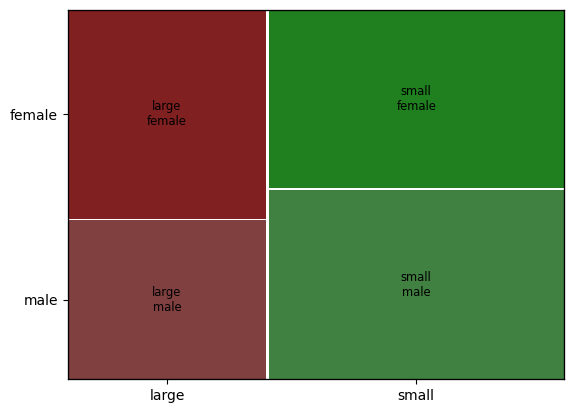

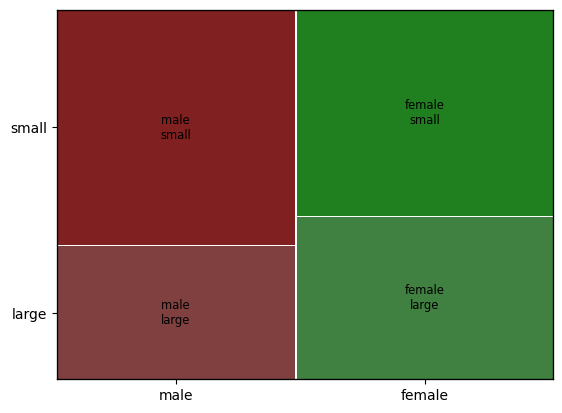

In [9]:
from statsmodels.graphics.mosaicplot import mosaic

mosaic(chat, ["submission", "gender"])
plt.show()
mosaic(chat, ["gender", "submission"])
plt.show()

> ##### Question:
> How to interpret the plot?

## Data exploration and visualization (2)

Let us now check whether we can observe a gender difference in emoji use. Start with some basic plots.
- Make a scatterplot of `emoticons` vs `nr_tokens`, colored by gender

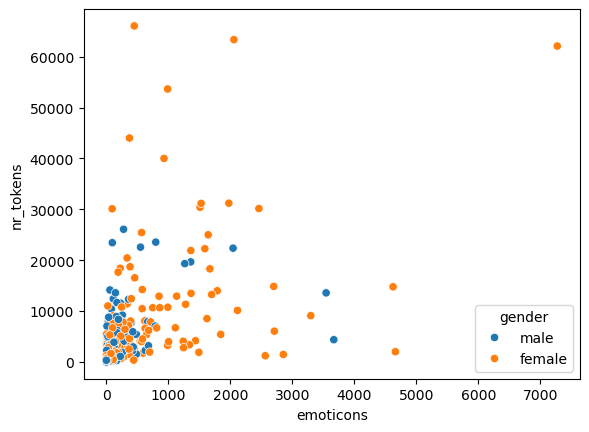

In [10]:
sns.scatterplot(chat, x="emoticons", y="nr_tokens", hue="gender")
plt.show()

Since the submission size (number of donated tokens: see variable `nr_tokens`) differs among the participants, first create a new variable called "emoticons_relative" by dividing the number of emoticons used by the number of tokens. You can inspect this new numeric variable with `summary()`

In [11]:
chat["emot_rel"] = chat["emoticons"] / chat["nr_tokens"]
chat.emot_rel.describe()

count    1384.000000
mean        0.061295
std         0.196771
min         0.000000
25%         0.000000
50%         0.013634
75%         0.055298
max         3.000000
Name: emot_rel, dtype: float64

Visualize in a `boxplot` and a `kdeplot` colored by gender.


> ##### Question:
> What is striking from this boxplot?

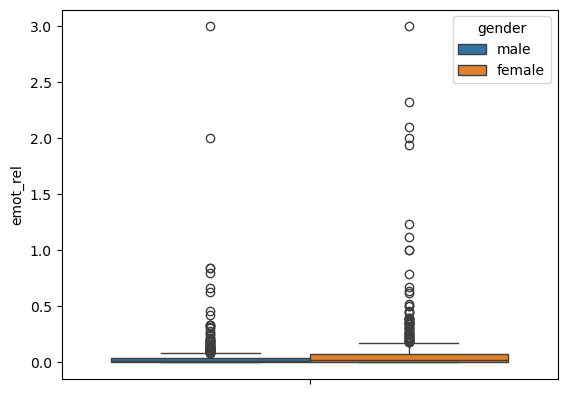

In [12]:
sns.boxplot(chat, y="emot_rel", hue="gender")
plt.show()

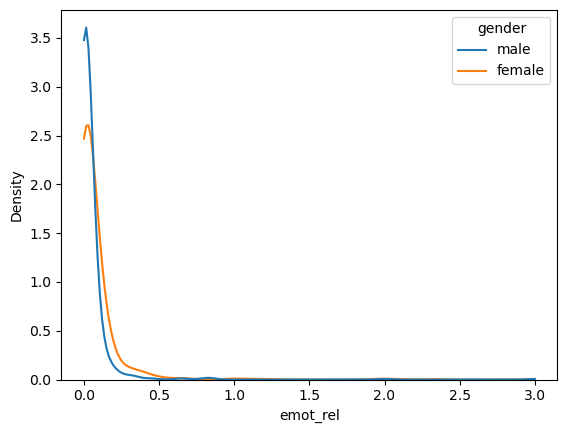

In [13]:
sns.kdeplot(chat, x="emot_rel", hue="gender", cut=0)
plt.show()

As a simple cutoff, delete datapoints with a ratio of >1 for emoji/nr_tokens. Subset the data using `[ ]` and insert your condition as above. Can you check how many datapoints you 'lost'?

In [14]:
chat_cut = chat[chat.emot_rel <= 1]
chat.shape[0] - chat_cut.shape[0]

9

Create the boxplot again. It should show fewer outliers (extreme datapoints) now.

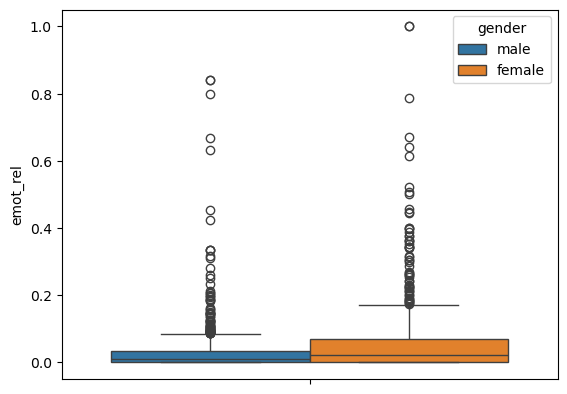

In [15]:
sns.boxplot(chat_cut, y="emot_rel", hue="gender")
plt.show()

We note that there are still some pretty bad outliers. Last time we used $z$-scaling. This time we will use another common cutoff to delete outliers (i.e. a widely applied rule of thumb),  and delete items that are 1.5 times or more the interquartile range (IQR) above the third quartile, and 1.5 times or more the IQR below the first quartile. To get the IQR, either use `quantile()`or `describe()`.

Check how many datapoints we lost this time: you'll see that this cutoff is a lot more drastic!

In [16]:
q1, q3 = chat.emot_rel.quantile([0.25, 0.75])
iqr = q3 - q1
print(f"IQR: {iqr}")

IQR: 0.055297847016176085


In [17]:
chat_extracut = chat[
    (chat.emot_rel >= (q1 - 1.5 * iqr)) & (chat.emot_rel <= (q3 + 1.5 * iqr))
]
chat.shape[0] - chat_extracut.shape[0]

129

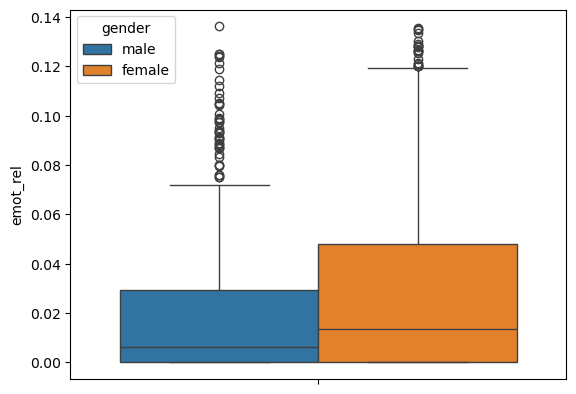

In [18]:
sns.boxplot(chat_extracut, y="emot_rel", hue="gender")
plt.show()

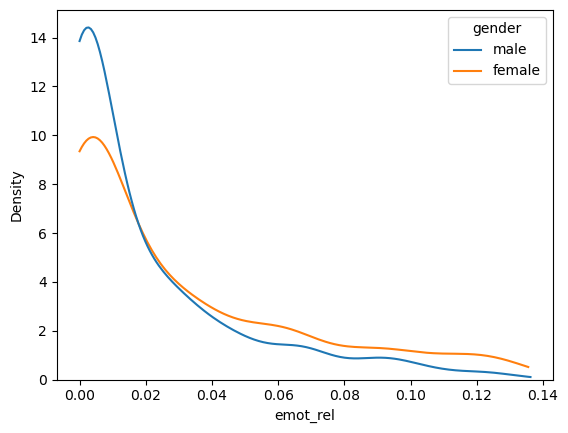

In [19]:
sns.kdeplot(chat_extracut, x="emot_rel", hue="gender", cut=0)
plt.show()

# Comparison with chat_repeated: repeated measurements

As you may have read on the slides on the different datasets, chat_repeated is a larger version of chat. An important difference is that chat_repeated (hence its name...) contains **repeated measurements**, i.e. multiple observations for one and the same subject. This issue of **dependent data** (including repeated measurements) versus **independent data** (no repeated measurements) will become very important later in the course, since data independence is a major assumption for many statistical tests and models (and alternative methods need to be applied to dependent data). Right now, we just show how to verify whether or not your dataset contains such repeated measurements.

> ##### EXERCISE
> Let's start with chat. Are there multiple observations (datapoints) for 1 subject? There are multiple ways to do this!

In [20]:
# code here

Now do the same for chat_repeated. Load the dataset first.

In [21]:
# code here

```
Version History

Current: v1.0.1

27/9/24: 1.0.0: first draft, BN
08/10/24: 1.0.1: proofread + typos, MK
```